# Проект: Оценка риска ДТП


__Заказчик__: каршеринговая компания.

__Цель проекта__: разработка системы, которая могла бы оценить риск ДТП по выбранному маршруту движения.

_Справочно:  под риском понимается вероятность ДТП с любым повреждением транспортного средства._

__Идея решения заказчика__:

Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

На основе модели исследовать основные факторы ДТП.

Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?


__Описание данных__:  база данных по происшествиям.

_Краткое описание таблиц:_

`collisions` — общая информация о ДТП

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

`parties` — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

`vehicles` — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

__План работы__:

- загрузка таблиц sql
- первичное исследование таблиц
- статистический анализ факторов ДТП
- создание моделей для оценки водительского риска
- выбор и оценка наилучшей модели 
- общий вывод

## Подготовка к исследованию

In [ ]:
#!pip install -q scikit-learn==1.1.3 

In [ ]:
#!pip install -q phik

In [ ]:
# импорты
import time
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from phik import phik_matrix
from sqlalchemy import create_engine, inspect, text

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score,  \
     confusion_matrix, precision_recall_curve, precision_score, \
     recall_score, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# игнорирование предупреждений
warnings.filterwarnings("ignore", category=UserWarning)

# константы
TEST_SIZE = 0.25
TITLE_SIZE = 16
LABEL_SIZE = 14
RANDOM_STATE = 42

## Подключение к базе данных

In [ ]:
#  данные для авторизации
db_config = {
'user': 'student', # имя пользователя,
'pwd': 'Sqw4$2;d-d59pp', # пароль,
'host': 'we7b-rtoijxj5yxfsf5fs.mdb.yandexcloud.net',
'port': 6342, # порт подключения,
'db': 'accidents-db' # название базы данных,
} 

# строка для соединения с базой данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

# создаем соединение
engine = create_engine(connection_string)

## Первичное исследование таблиц

Мы должны работать с тремя таблицами: `collisions`, `parties`, `vehicles`. Также на диаграмме присутствует `case_ids`(описание не предоставлено). Получим список имен таблиц в базе. Проверим наличие данных в таблицах.

In [7]:
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['collisions', 'case_ids', 'parties', 'vehicles']

In [8]:
for table_name in table_names:

    with engine.connect() as connection:
        row_count = connection.execute(text(f"SELECT COUNT(*) FROM {table_name}")).scalar()
        print(f"Таблица: {table_name}, количество записей: {row_count}")

        query_sample = f'''
                        SELECT *
                        FROM {table_name}
                        LIMIT 5'''
        sample_data = pd.read_sql_query(query_sample, con = engine)
        display(sample_data)
   
    columns = inspector.get_columns(table_name)
    print("Столбцы:")
    for column in columns:
        column_name = column['name']
        column_type = str(column['type'])  # Тип данных столбца
        print(f"  {column_name}: {column_type}")
    print()

Таблица: collisions, количество записей: 1400000


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Столбцы:
  case_id: TEXT
  county_city_location: TEXT
  county_location: TEXT
  distance: REAL
  direction: TEXT
  intersection: INTEGER
  weather_1: TEXT
  location_type: TEXT
  collision_damage: TEXT
  party_count: INTEGER
  primary_collision_factor: TEXT
  pcf_violation_category: TEXT
  type_of_collision: TEXT
  motor_vehicle_involved_with: TEXT
  road_surface: TEXT
  road_condition_1: TEXT
  lighting: TEXT
  control_device: TEXT
  collision_date: DATE
  collision_time: TIME

Таблица: case_ids, количество записей: 1400000


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Столбцы:
  case_id: TEXT
  db_year: TEXT

Таблица: parties, количество записей: 2752408


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Столбцы:
  id: INTEGER
  case_id: TEXT
  party_number: INTEGER
  party_type: TEXT
  at_fault: INTEGER
  insurance_premium: INTEGER
  party_sobriety: TEXT
  party_drug_physical: TEXT
  cellphone_in_use: INTEGER

Таблица: vehicles, количество записей: 1021234


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


Столбцы:
  id: INTEGER
  case_id: TEXT
  party_number: INTEGER
  vehicle_type: TEXT
  vehicle_transmission: TEXT
  vehicle_age: INTEGER



В базе присутствуют все таблицы, указанные в описании данных. Каждая из указанных таблиц не является пустой и содержит значительное количество записей. В таблицах `vehicles` и `parties` для связи есть поля `case_id` and `party_number`, сочетание которых является уникальным ключом. Для связи с таблицой `collisions` будет использоваться поле `case_id`. Описание таблиц соответствует действительности не для всех случаев.

В описании таблиц нет информации о `case_ids`. В ней содержатся всего 2 столбца. Изучим подробнее, что в ней содержится.

In [9]:
query_case_ids = '''
SELECT db_year,
       COUNT(case_id)
FROM case_ids
GROUP BY db_year
'''

case_ids = pd.read_sql_query(query_case_ids, con = engine)
case_ids

,db_year,count
0,2021,1400000


Опираться на по поле `db_year` при получении данных за определенный период мы не можем. Наиболее вероятно, что данные вносились в базу единовременно в 2021 году. Значит, нам нужно использовать поле `collision_date` из таблицы `collisions`. 

Таблица `case_ids` для проведения дальнейшего исследования не требуется.

__Промежуточный вывод:__

- в базе содержатся непустые таблицы, отображенные на ER диаграмме (`collisions` - 1 400 000 записей, `case_ids` - 1 400 000 записей, `parties` - 2 752 408 записей, `vehicles` - 1 021 234 записей);
- для проведения дальнейшего исследования данных достаточно, таблица `case_ids` не требуется;
- в таблицах `vehicles` и `parties` для связи есть поля `case_id` and `party_number`, сочетание которых является уникальным ключом, для связи с таблицой `collisions` будет использоваться поле `case_id`.

## Статистический анализ факторов ДТП

### Задача: _Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions)._

Посмотрим, как представлены данные за разные месяцы.

In [10]:
collisions_by_period_query = '''
SELECT DATE_TRUNC('month', CAST(collision_date AS timestamp)) AS collision_date_month,
       COUNT(*)
FROM collisions
GROUP BY collision_date_month
'''

collisions_by_period = pd.read_sql_query(collisions_by_period_query, con = engine)
collisions_by_period

,collision_date_month,count
0,2009-01-01,35062
1,2009-02-01,34480
2,2009-03-01,36648
3,2009-04-01,35239
4,2009-05-01,36916
5,2009-06-01,34202
6,2009-07-01,35161
7,2009-08-01,34508
8,2009-09-01,35555
9,2009-10-01,37835


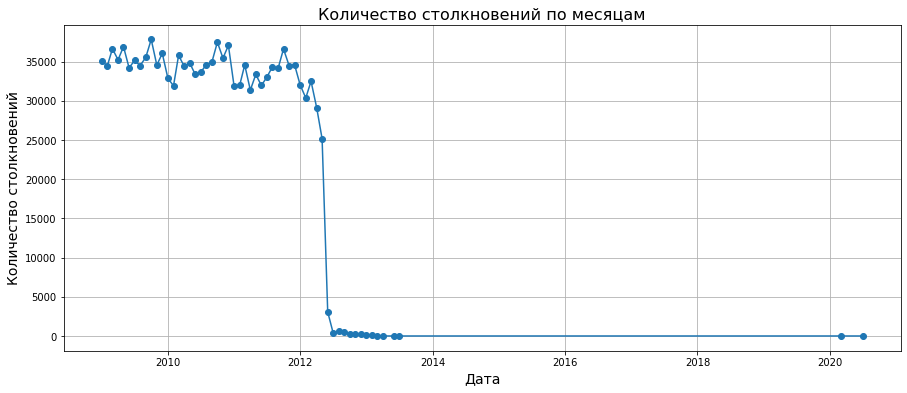

In [11]:
# Построение графика
_, ax = plt.subplots(figsize=(15, 6))
plt.plot(collisions_by_period['collision_date_month'], collisions_by_period['count'], marker='o')
plt.title('Количество столкновений по месяцам', fontsize=TITLE_SIZE)
plt.xlabel('Дата', fontsize=LABEL_SIZE)
plt.ylabel('Количество столкновений', fontsize=LABEL_SIZE)
plt.grid(True)
plt.show()

С января 2009 по апрель 2012 года в базе есть информация о примерно 30 000 ДТП в месяц. Затем это число заметно снижается. Такое резкое снижение скорее говорит нам о прекращении внесения данных за последующие периоды, чем о резком снижении аварийности.

> Заказчик предлагает для моделирования ограничиться данными за 2012 год — они самые свежие. 

Данные за 2012 год внесены не полностью, они не будут в полной мере отражать аварийность на дороге, это может привести к построению неверных зависимостей и ошибочным результатам моделирования. Модель, возможно, будет неплохо предсказывать только для первых 5 месяцев года. Стоит обсудить с заказчиком использование данных за период с мая 2011 по апрель 2012 года. Это даст полные данные за год (за каждый из 12 месяцев) и позволит учесть сезонность поездки.

Проанализируем данные о ДТП в разрезе по месяцам. Т.к. данные с 2012 года внесены не в полном объеме, не будем их учитывать в следующем запросе.

,month_name,count
1,Февраль,98373
5,Июнь,99531
0,Январь,99880
3,Апрель,101032
6,Июль,101835
7,Август,103467
10,Ноябрь,104517
8,Сентябрь,104649
4,Май,105148
2,Март,107036


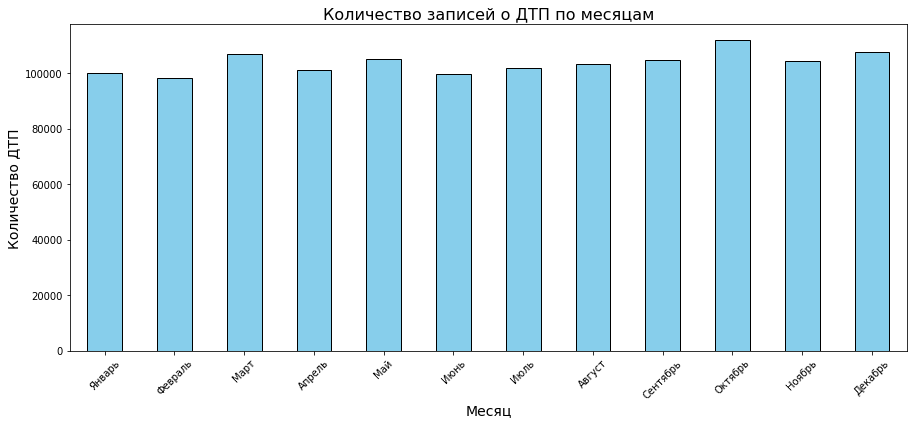

In [12]:
collisions_by_month_query = '''
SELECT EXTRACT(MONTH FROM CAST(collision_date AS timestamp))::int AS month,
       COUNT(*)
FROM collisions
WHERE EXTRACT(YEAR FROM CAST(collision_date AS timestamp)) < 2012
GROUP BY month
'''

collisions_by_month = pd.read_sql_query(collisions_by_month_query, con = engine)
collisions_by_month = collisions_by_month.sort_values(by='month')

months = [
    'Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 
    'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'
]
collisions_by_month['month_name'] = collisions_by_month['month'].apply(lambda x: months[x - 1])
display(collisions_by_month[['month_name', 'count']].sort_values(by='count'))

_, ax = plt.subplots(figsize=(15, 6))
collisions_by_month.plot(kind='bar', x='month_name', y='count',
                               legend=False, color='skyblue', edgecolor='black', rot=45, ax=ax)
plt.title('Количество записей о ДТП по месяцам', fontsize=TITLE_SIZE)
plt.ylabel('Количество ДТП', fontsize=LABEL_SIZE)
plt.xlabel('Месяц', fontsize=LABEL_SIZE)
plt.show()

Наибольшее количество ДТП за период с 2009 по 2011 годы наблюдалось в октябре (111933), наименьшее - в феврале (98373). Никаких особенностей не наблюдается.

In [13]:
collisions_by_month_year_query = '''
SELECT EXTRACT(YEAR FROM CAST(collision_date AS timestamp))::int AS year,
       EXTRACT(MONTH FROM CAST(collision_date AS timestamp))::int AS month,
       COUNT(*)
FROM collisions
WHERE DATE_TRUNC('month', CAST(collision_date AS timestamp)) <= '2012-05-01'
GROUP BY year, month
'''

collisions_by_month_year = pd.read_sql_query(collisions_by_month_year_query, con = engine)

pivot_table = collisions_by_month_year.pivot_table(
    index='year',  
    columns='month',    
    values='count', 
    fill_value=0       
)

styled_table = (
    pivot_table
    .style.highlight_max(axis=1, color='lightcoral')
    .highlight_min(axis=1, color='lightgreen'))
styled_table

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2009,35062,34480,36648,35239,36916,34202,35161,34508,35555,37835,34562,36060
2010,32892,31918,35803,34416,34862,33367,33645,34620,34957,37480,35460,37070
2011,31926,31975,34585,31377,33370,31962,33029,34339,34137,36618,34495,34615
2012,32020,30377,32498,29143,25168,0,0,0,0,0,0,0


Как общую тенденцию можно выделить то, что с 2009 по 2011 годы наибольшее число ДТП приходилось на октябрь (данные за октябрь 2012 года отсутствуют). 

In [14]:
collisions_countries_query = '''
SELECT county_location,
       COUNT(*)
FROM collisions
GROUP BY county_location
'''

collisions_countries = pd.read_sql_query(collisions_countries_query, con = engine)
collisions_countries

,county_location,count
0,alameda,64553
1,alpine,290
2,amador,1741
3,butte,6394
4,calaveras,1870
5,colusa,1086
6,contra costa,31492
7,del norte,1207
8,el dorado,5562
9,fresno,26476


Географические районы, в которых произошло ДТП, это округи штата Калифорния. Повышенная аварийность в октябре может быть связана с особенностями климата.

### Постановка задач для проведения анализа

Для лучшего понимания данных могут быть поставлены следующие аналитические задачи: 

1) Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать `collisions` и `parties`, поле `ROAD_SURFACE`).

2) Проведите анализ серьёзности повреждений транспортного средства, исходя из дорожного состояния при разных погодных условиях (связать `collisions` и `parties`, поле `ROAD_CONDITION_1`).  

3) Найдите самые частые причины ДТП (таблица `collisions`).

4) Проведите анализ количества ДТП с учетом типа КПП автомобиля (связать `collisions` и `vehicles`).

5) Проанализируйте частоту ДТП при разной освещенности (таблица `collisions`).

6) Проведите анализ серьезности повреждений в зависимости от возраста автомобиля (связать `collisions` и `vehicles`).

7) Проанализируйте взаимосвязь аварийности и наличия в автомобиле возможности разговаривать по громкой связи (связать `collisions` и `parties`).

8) Проведите анализ аварийности в зависимости от трезвости участника ДТП (связать `collisions` и `parties`).

#### Задача: _анализ серьезности повреждений в зависимости от возраста автомобиля_

Порядок выполнения:
- Создайте sql-запрос. Объедините таблицы `collisions` и `vehicles`. Создайте дополнительное поле для категоризации авто по возрасту. Получите информацию о количестве повреждений каждого типа для каждой из категорий.
- Постройте график.
- Сделайте вывод.

In [15]:
collisions_cars_query = '''
SELECT CASE 
         WHEN v.vehicle_age <= 3 THEN 'age <= 3'
         WHEN v.vehicle_age > 3 AND v.vehicle_age <= 5 THEN '3 < age <= 5'
         WHEN v.vehicle_age > 5 AND v.vehicle_age <= 10 THEN '5 < age <= 10'
         WHEN v.vehicle_age > 10 THEN 'age > 10'
         ELSE 'unknown'
       END AS age,
       c.collision_damage AS damage,
       COUNT(*) AS count
FROM collisions AS c
JOIN vehicles AS v ON c.case_id = v.case_id
WHERE v.vehicle_age IS NOT NULL
GROUP BY age, damage
'''

collisions_cars = pd.read_sql_query(collisions_cars_query, con = engine)

total_counts = collisions_cars.groupby("age")["count"].transform("sum")
collisions_cars["percent"] = (collisions_cars["count"] * 100 / total_counts).round(2)

collisions_cars

,age,damage,count,percent
0,3 < age <= 5,fatal,3373,1.46
1,3 < age <= 5,middle damage,52032,22.57
2,3 < age <= 5,scratch,108994,47.28
3,3 < age <= 5,severe damage,9740,4.23
4,3 < age <= 5,small damage,56368,24.45
5,5 < age <= 10,fatal,6157,1.80
6,5 < age <= 10,middle damage,72842,21.27
7,5 < age <= 10,scratch,181714,53.07
8,5 < age <= 10,severe damage,15444,4.51
9,5 < age <= 10,small damage,66269,19.35


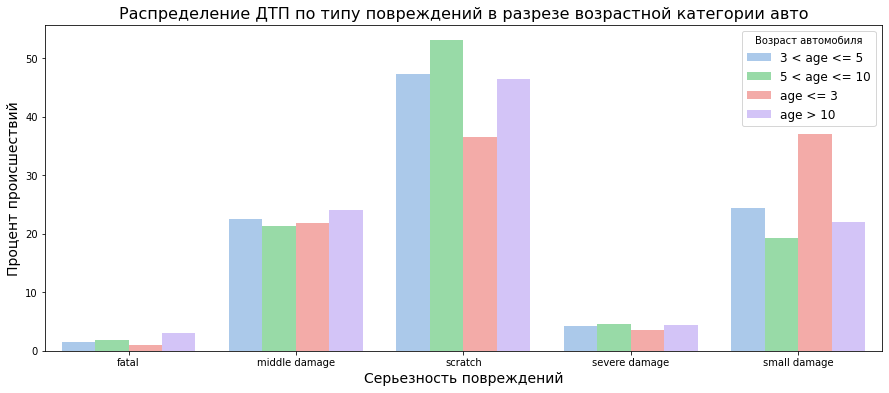

In [16]:
plt.subplots(figsize=(15, 6))
sns.barplot(data=collisions_cars, x="damage", y="percent", hue="age", palette="pastel6")
plt.title("Распределение ДТП по типу повреждений в разрезе возрастной категории авто", fontsize=TITLE_SIZE)
plt.xlabel("Серьезность повреждений", fontsize=LABEL_SIZE)
plt.ylabel("Процент происшествий", fontsize=LABEL_SIZE)
plt.legend(title="Возраст автомобиля", fontsize=12)
plt.show()

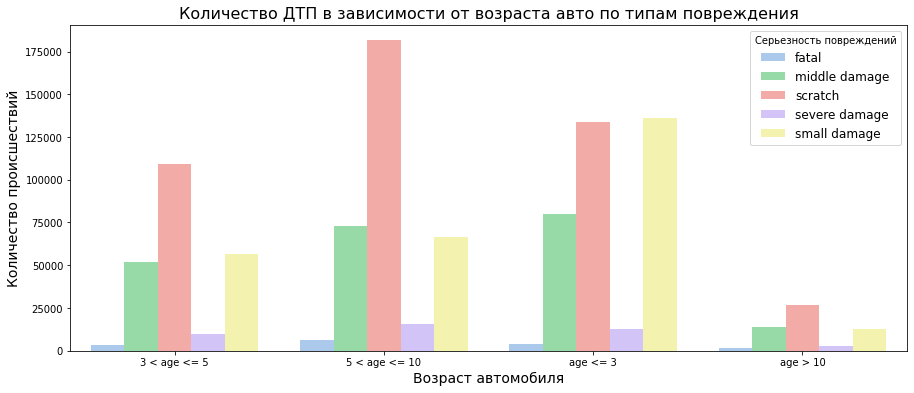

In [17]:
plt.subplots(figsize=(15, 6))
sns.barplot(data=collisions_cars, x="age", y="count", hue="damage", palette="pastel6")
plt.title("Количество ДТП в зависимости от возраста авто по типам повреждения", fontsize=TITLE_SIZE)
plt.xlabel("Возраст автомобиля", fontsize=LABEL_SIZE)
plt.ylabel("Количество происшествий", fontsize=LABEL_SIZE)
plt.legend(title="Серьезность повреждений", fontsize=12)
plt.show()

Наиболее часто встречаются повреждения типа scratch (царапины). На втором месте - малые (отдельный элемент кузова под замену/покраску) и средние (средний ремонт, машина в целом на ходу) повреждения. Серьезные и не подлежащие восстановлению повреждения встречаются гораздо реже. 
Это говорит о том, что большинство ДТП приводят к незначительным повреждениям. Из общих тенденций выделяется только группа авто, которым менее 3 лет: для них зафиксировано практически равное число небольших повреждений и царапин. 

Автомобили старше 10 лет имеют наибольшую долю повреждений типа fatal (3.02%). Это может быть связано с ухудшением технического состояния старых автомобилей.

#### Задача: _анализ количества ДТП по основным факторам аварий с учетом типа КПП автомобиля_

Порядок выполнения:
- Создайте sql-запрос. Объедините таблицы `collisions` и `vehicles`. Получите информацию о количестве повреждений для авто с разными типами КПП по основным факторам аварий.
- Постройте график.
- Сделайте вывод.

In [18]:
collisions_transmission_query = '''
SELECT v.vehicle_transmission AS transmission,
       c.primary_collision_factor AS primary_factor,
       COUNT(*) AS count
FROM collisions AS c
JOIN vehicles AS v ON c.case_id = v.case_id
GROUP BY v.vehicle_transmission, c.primary_collision_factor
'''

collisions_transmission = pd.read_sql_query(collisions_transmission_query, con = engine)
collisions_transmission = collisions_transmission.fillna('unknown')
collisions_transmission.groupby('transmission').agg(sum)

,count
transmission,
auto,502243
manual,495332
unknown,23659


Число ДТП с участием машин, по которым данных о типе КПП нет, значительно меньше, чем с участием остальных. Их не будем выводить на график. Общее число ДТП немного выше для машин с АКПП.

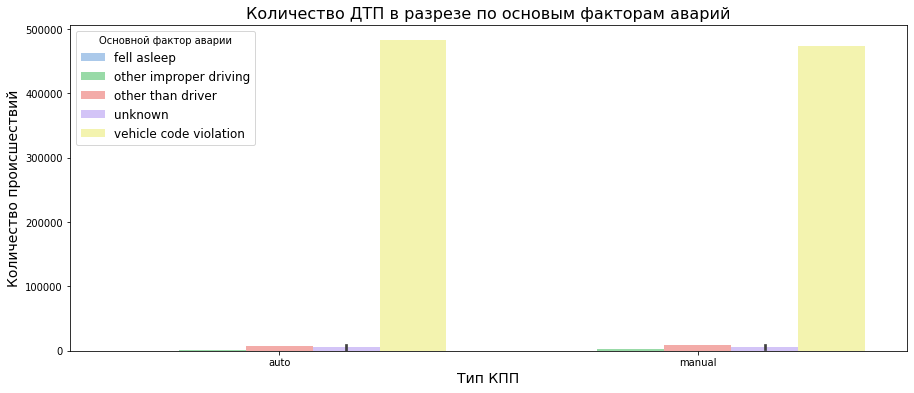

In [19]:
plt.subplots(figsize=(15, 6))
sns.barplot(
    data=collisions_transmission[collisions_transmission['transmission']
                                 .isin(['auto', 'manual'])],
    x="transmission", y="count", hue="primary_factor", palette="pastel6")

plt.title("Количество ДТП в разрезе по основым факторам аварий", fontsize=TITLE_SIZE)
plt.xlabel("Тип КПП", fontsize=LABEL_SIZE)
plt.ylabel("Количество происшествий", fontsize=LABEL_SIZE)
plt.legend(title="Основной фактор аварии", fontsize=12)
plt.show()

Распределения выглядят похоже. Большинство ДТП случались из-за нарушения ПДД. 

_Вывод_: не удалось выявить зависимость количества ДТП / основных факторов ДТП от типа КПП. Преобладающее большинство аварий вызвано нарушением ПДД.

__Промежуточный вывод__: 
- С января 2009 по апрель 2012 года в базе есть информация о примерно 30 000 ДТП в месяц. Затем это число заметно снижается до полного отсутствия записей за последующие периоды.
- Наибольшее количество ДТП за период с 2009 по 2011 годы наблюдалось в октябре (111933), наименьшее - в феврале (98373). Никаких особенностей не наблюдается. Самый аварийный месяц в разрезе по годам - октябрь.
- Наиболее часто встречаются повреждения типа scratch, на втором месте - малые и средние повреждения, гораздо реже - серьезные и не подлежащие восстановлению повреждения. Для авто, которым менее 3 лет, зафиксировано практически равное число небольших повреждений и царапин. Автомобили старше 10 лет имеют наибольшую долю повреждений типа fatal. 
- Преобладающее большинство аварий вызвано нарушением ПДД. Зависимость количества ДТП / основных факторов ДТП от типа КПП не наблюдается. 

## Создание модели для оценки водительского риска

### Получение набора данных

На данном этапе работы от нас требуется использовать набор данных на основе первичного предложения заказчика.

In [20]:
# используем JOIN, т.к. нам нужны только те строки, где есть совпадения во всех трех таблицах.

query = '''
SELECT *,
       EXTRACT(MONTH FROM CAST(c.collision_date AS timestamp))::int AS collision_month,
       EXTRACT(ISODOW FROM CAST(c.collision_date AS timestamp))::int AS collision_isodow,
       CASE
         WHEN COLLISION_TIME BETWEEN '06:00' AND '11:59' THEN 'morning'
         WHEN COLLISION_TIME BETWEEN '12:00' AND '17:59' THEN 'afternoon'
         WHEN COLLISION_TIME BETWEEN '18:00' AND '23:59' THEN 'evening'
         ELSE 'night'
       END AS time_period,
       CASE 
         WHEN v.vehicle_age <= 3 THEN 'age <= 3'
         WHEN v.vehicle_age > 3 AND v.vehicle_age <= 5 THEN '3 < age <= 5'
         WHEN v.vehicle_age > 5 AND v.vehicle_age <= 10 THEN '5 < age <= 10'
         WHEN v.vehicle_age > 10 THEN 'age > 10'
         ELSE 'unknown'
       END AS age
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car'
  AND c.collision_damage !='scratch'
  AND EXTRACT(YEAR FROM CAST(c.collision_date AS timestamp)) = 2012
''' 
data = pd.read_sql_query(query, con = engine)

In [21]:
data.head().T

,0,1,2,3,4
case_id,5454402,5612888,5613058,5613642,5614237
county_city_location,3711,3026,1900,0109,3708
county_location,san diego,orange,los angeles,alameda,san diego
distance,1500.0,40.0,0.0,1900.0,506.0
direction,south,north,None,west,east
intersection,0.0,0.0,1.0,0.0,0.0
weather_1,clear,clear,clear,clear,clear
location_type,highway,None,None,highway,highway
collision_damage,middle damage,small damage,small damage,small damage,small damage
party_count,2,2,2,4,2


In [22]:
data.columns

Index(['case_id', 'county_city_location', 'county_location', 'distance',
       'direction', 'intersection', 'weather_1', 'location_type',
       'collision_damage', 'party_count', 'primary_collision_factor',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'collision_date', 'collision_time', 'id',
       'case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'id', 'case_id', 'party_number', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'collision_month',
       'collision_isodow', 'time_period', 'age'],
      dtype='object')

### Первичный отбор признаков

Проведем первичный отбор факторов, необходимых для модели.

Поля, которые можно исключить, т.к. они не несут полезной информации:
- идентификаторы (case_id, id, party_number	)
- collision_date, collision_time (т.к. при формировании таблицы мы уже извлекли номер месяца и день недели, период суток)
- party_type (только одно значение)

Также исключим:
- direction
- distance (расстояние от главной дороги, нам пригодился бы признак, если бы содержал расстояние от места старта до пункта назначения)
- insurance_premium
- vehicle_type 

Не можем знать до момента ДТП:
- collision_damage
- primary_collision_factor
- party_count
- pcf_violation_category
- type_of_collision
- motor_vehicle_involved_with
- party_drug_physical
- party_sobriety (даже если проверять при посадке с использованием специальных приборов + камер, нет способа проконтролировать изменение в течение поездки)

In [23]:
columns = [# collisions
           'county_city_location', # интенсивность движения может быть разной в зависимости от географического района
           'county_location',
           'intersection', # перекрестки - места повышенной опасности, где часто происходят дтп
           'weather_1', # влияет на видимость и состояние дорожного покрытия
           'location_type', # характеризует интенсивность и скоростные ограничения
           'road_surface', # влияет на управляемость автомобилем
           'road_condition_1', # влияет на управляемость автомобилем, скоростные ограничения
           'lighting', # влияет на видимость
           'control_device', # неработающие светофоры оказывают влияние на поток
           'collision_month', # определяет сезонность
           'collision_isodow', # характеризует интенсивность движения, особенно в сочетании с периодом суток
           'time_period', # характеризует видимость и интенсивность движения
           # parties
           'at_fault', # целевой признак
           'cellphone_in_use', # влияет на способность принимать звонки, не отвлекаясь от дороги
           # vehicles
           'vehicle_transmission', # может косвенно влиять на сложность управления при недостаточном опыте водителя,
            # на динамику, на степень контроля над авто
           'vehicle_age',
           'age'] # влияет на вероятность поломки авто, в т.ч. во время движения

data = data[columns]
data.sample(5).T

,11884,2356,30572,43491,28006
county_city_location,3104,1000,4100,1942,1941
county_location,placer,fresno,san mateo,los angeles,los angeles
intersection,NaN,1.0,0.0,1.0,0.0
weather_1,clear,clear,cloudy,clear,clear
location_type,None,None,ramp,None,None
road_surface,dry,dry,dry,dry,dry
road_condition_1,normal,normal,normal,normal,construction
lighting,daylight,daylight,daylight,dark with street lights,daylight
control_device,none,functioning,none,functioning,none
collision_month,5,4,2,1,5


Изучим данные подробнее.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  56248 non-null  object 
 1   county_location       56248 non-null  object 
 2   intersection          56073 non-null  float64
 3   weather_1             56080 non-null  object 
 4   location_type         25932 non-null  object 
 5   road_surface          55900 non-null  object 
 6   road_condition_1      55999 non-null  object 
 7   lighting              56094 non-null  object 
 8   control_device        56033 non-null  object 
 9   collision_month       56248 non-null  int64  
 10  collision_isodow      56248 non-null  int64  
 11  time_period           56248 non-null  object 
 12  at_fault              56248 non-null  int64  
 13  cellphone_in_use      51777 non-null  float64
 14  vehicle_transmission  55389 non-null  object 
 15  vehicle_age        

### Предобработка данных

In [25]:
temp = data.copy()
len(temp)

56248

Изучим пропуски.

In [26]:
missing_values = data.isna().sum()
missing_percent = round((missing_values / len(data)) * 100, 2)

missing_data = pd.DataFrame({
    'missing values': missing_values,
    'percent': missing_percent
})

missing_data.sort_values(by='percent', ascending=False)

,missing values,percent
location_type,30316,53.90
cellphone_in_use,4471,7.95
vehicle_age,1694,3.01
vehicle_transmission,859,1.53
road_surface,348,0.62
road_condition_1,249,0.44
control_device,215,0.38
intersection,175,0.31
weather_1,168,0.30
lighting,154,0.27


Пропуски в данных присутствуют. Предварительно определим стратегию работы с ними: заполним пропуски в категориальных столбцах значением по умолчанию `unknown`, данные о возрасте авто - медианным значением.
Пропуски в cellphone_in_use и intersection заполним нулями (считаем, что это не перекресток и возможности использовать громкую связь нет).

Пропусков в целевом признаке нет.

Выполним минимальную предобработку категориальных значений. Удалим явные дубликаты, если они имеются.

In [27]:
cat_columns = data.select_dtypes(include='object').columns.tolist()
for col in cat_columns:
    data[col] = data[col].str.strip().str.lower()
    
data.duplicated().sum()

1160

In [28]:
data = data.drop_duplicates().reset_index(drop=True)

Т.к. в данных много категориальных признаков, будем устранять возможные проблемы при их изучении, после чего выполним проверку на дубликаты повторно.

### Исследовательский анализ данных

In [29]:
def analyze_categorical_data(data, column, column_to_calculate):
    """
    Функция используется при анализе категориальных данных.

    Args:
        data (DataFrame): датафрейм
        column (string): столбец для анализа
        column_to_calculate (string): столбец, используемый для подсчетов
    Returns:
        agg_data - агрегированные данные
    """
    agg_data = (
    data
    .groupby(column) 
    .agg(count=(column_to_calculate, 'count'), share_of_pos_target=(column_to_calculate, 'mean')))
    display(agg_data.sort_values(by='share_of_pos_target', ascending=False))
    return agg_data

In [30]:
def analyze_numerical_data(data, column, title, bins_number=100):
    """
    Функция помогает при проведении статистического анализа количественных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.
    Может принимать bins для построения графика.

    Выводит для колонки:
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха
    """

    print(data[column].describe())
     
    median = data[column].median()
    mean = data[column].mean()
        
    # Создаем фигуру и оси для гистограммы
    fig, ax = plt.subplots(2, 1, figsize=(17, 10))

    # Гистограмма
    ax[0].hist(data[column], bins=bins_number, color='skyblue')
    ax[0].set_title(f'Гистограмма для признака "{title}"', fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(True)
    
    ax[0].axvline(median, color='green', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median:.2f}')
    ax[0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean:.2f}')
    ax[0].legend()

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"', fontsize=TITLE_SIZE)
    
    plt.tight_layout()
    # Установка вертикального отступа между графиками
    plt.subplots_adjust(hspace=0.3)
    plt.show()

Изучим значения таргета. Стоит отметить, что с учетом признака, выбранного целевым, речь идет о вероятности стать виновным в ДТП (т.к. признак содержит информацию о виновности участника).

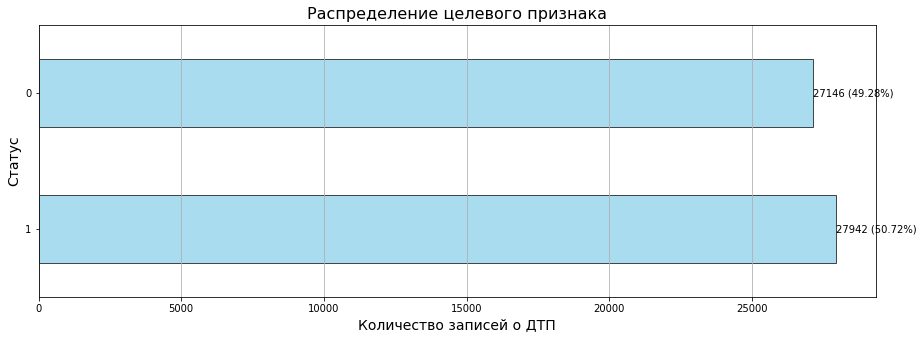

In [31]:
value_counts = data['at_fault'].value_counts()
percentages = (value_counts / len(data)) * 100
status_counts = pd.DataFrame({'count': value_counts, 'percentage': percentages})

# Построение графика
plt.figure(figsize=(15, 5))
status_counts['count'].plot(kind='barh', color='skyblue', alpha=0.7, edgecolor='black')

# Добавление подписей с числами и процентами
for index, value in enumerate(status_counts['count']):
    plt.text(value + 0.05, index, f"{value} ({status_counts['percentage'].iloc[index]:.2f}%)", va='center')

plt.title('Распределение целевого признака', fontsize=TITLE_SIZE)
plt.xlabel('Количество записей о ДТП', fontsize=LABEL_SIZE)
plt.ylabel('Статус', fontsize=LABEL_SIZE)
plt.grid(axis='x')
plt.show()

Количество записей, когда участники виновны, незначительно превышает число случаев, когда участники не виновны - 50,72% и 49,28% соответсвенно.

Посмотрим подробнее на географические данные. Мы уже выяснили, что данные содержат информацию о ДТП в Калифорнии.

In [32]:
data['county_city_location'].nunique()

496

In [33]:
data['county_location'].nunique()

58

In [34]:
_ = analyze_categorical_data(data, 'county_location', 'at_fault')

,count,share_of_pos_target
county_location,,
plumas,34,0.911765
sierra,14,0.857143
trinity,33,0.787879
inyo,71,0.760563
mariposa,60,0.733333
lake,115,0.730435
glenn,40,0.725000
mendocino,194,0.716495
amador,85,0.705882


Уникальных значений `county_city_location` слишком много, этот признак врядли будет полезен для моделирования. Для признака `county_location` представлено 58 уникальных значений. Доля положительных значений целевого признака варьируется от 0.29 до 0.91. Этот признак может быть полезным.

In [35]:
_ = analyze_categorical_data(data, 'intersection', 'at_fault')

,count,share_of_pos_target
intersection,,
0.0,42629,0.524572
1.0,12285,0.446724


В нашей выборке есть информация о ДТП на 12325 перекрестках, аварийность на перекрестках ниже - 44.6% против 52.4%.

Проверим признак `location_type`, т.к. одним из значений является intersection. Возможно, данные дублируются.

In [36]:
_ = analyze_categorical_data(data, 'location_type', 'at_fault')

,count,share_of_pos_target
location_type,,
ramp,3248,0.543103
highway,20674,0.495260
intersection,1340,0.461194


Самая высокая доля положительного значения целевого признака - при ДТП на съездах (54.3%), затем шоссе (49.6%) и перекрестки (46.1%). Количество перекрестков при анализе признаков разное, оставляем оба признака. 

In [37]:
grouped_data = analyze_categorical_data(data, 'weather_1', 'at_fault')

,count,share_of_pos_target
weather_1,,
snowing,156,0.685897
other,34,0.676471
fog,180,0.600000
raining,2162,0.581869
wind,11,0.545455
cloudy,8372,0.542403
clear,44005,0.496103


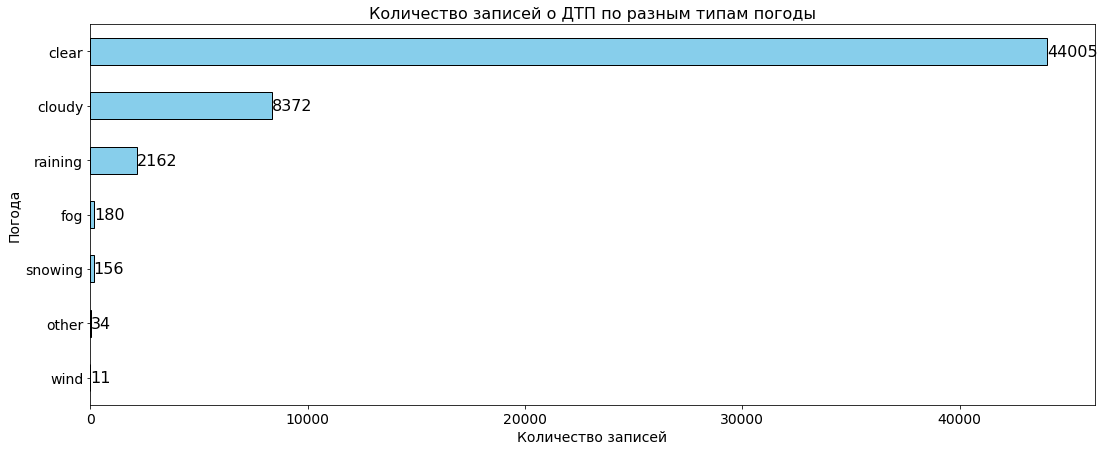

In [38]:
# построим столбчатую диаграмму
ax = grouped_data['count'].sort_values().plot.barh(
    legend=False, figsize = (18, 7), rot=0, fontsize=14,  color='skyblue', edgecolor='black')
ax.set_title('Количество записей о ДТП по разным типам погоды', fontsize = TITLE_SIZE)
ax.set_ylabel('Погода', fontsize = LABEL_SIZE)
ax.set_xlabel('Количество записей', fontsize = LABEL_SIZE)

# Выводим значения над каждым столбцом
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width() + 0.5, p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=16)
    
plt.show()

Большинство записей о ДТП, совершенных в ясную погоду. Далее - облачную и дождливую. Записей о ДТП в другую погоду значительно меньше. При этом наибольшая доля положительных значений целевого признака - при снегопаде.

In [39]:
for col in ['road_surface', 'road_condition_1',  'lighting', 'control_device', 'cellphone_in_use',
            #'vehicle_type', 
            'vehicle_transmission', 'time_period', 'collision_month',
            'collision_isodow', 'age']:
    _ = analyze_categorical_data(data, col, 'at_fault') 

,count,share_of_pos_target
road_surface,,
snowy,356,0.719101
wet,5224,0.592075
slippery,43,0.511628
dry,49119,0.496997


,count,share_of_pos_target
road_condition_1,,
flooded,32,0.718750
loose material,128,0.640625
reduced width,71,0.619718
other,228,0.557018
obstruction,247,0.514170
normal,52919,0.507625
holes,219,0.506849
construction,996,0.467871


,count,share_of_pos_target
lighting,,
dark with no street lights,5057,0.629227
dark with street lights,10798,0.537229
dark with street lights not functioning,135,0.511111
dusk or dawn,1761,0.492902
daylight,37183,0.482936


,count,share_of_pos_target
control_device,,
none,36635,0.537410
not functioning,116,0.491379
obscured,29,0.482759
functioning,18093,0.446471


,count,share_of_pos_target
cellphone_in_use,,
1.0,1047,0.540592
0.0,49609,0.503840


,count,share_of_pos_target
vehicle_transmission,,
manual,28698,0.551049
auto,25537,0.458511


,count,share_of_pos_target
time_period,,
night,5271,0.706507
evening,13024,0.501152
morning,13140,0.496347
afternoon,23653,0.472202


,count,share_of_pos_target
collision_month,,
10,262,0.603053
12,191,0.602094
7,326,0.579755
8,373,0.568365
11,264,0.560606
9,342,0.535088
6,1303,0.524942
4,10612,0.510837
2,10119,0.505287


,count,share_of_pos_target
collision_isodow,,
7,7918,0.534100
6,9125,0.522740
1,6960,0.511063
3,7402,0.506485
4,7553,0.494373
5,9071,0.491015
2,7059,0.488596


,count,share_of_pos_target
age,,
age <= 3,22117,0.559705
age > 10,3128,0.505115
3 < age <= 5,12395,0.503590
unknown,1677,0.493143
5 < age <= 10,15771,0.438400


Для всех выделенных нами признаков видим, что доля положительных значений таргета отличается в зависимости от категории. 

Наблюдаем наибольшую долю положительных значений целевого признака (виновности участника ДТП) в следующих случаях:
- снег и мокрое дорожное покрытие
- затопленные дороги и дороги с сыпучим материалом
- темное время суток, особенно без уличных фонарей
- отсутствие устройств управления (например, светофоров)
- ночное время
- автомобили с механической коробкой передач 
- наличие телефона в авто
- машины с кузовом 'coupe'
- машины возраста до 3 лет

count    53411.000000
mean         4.871169
std          3.249981
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64


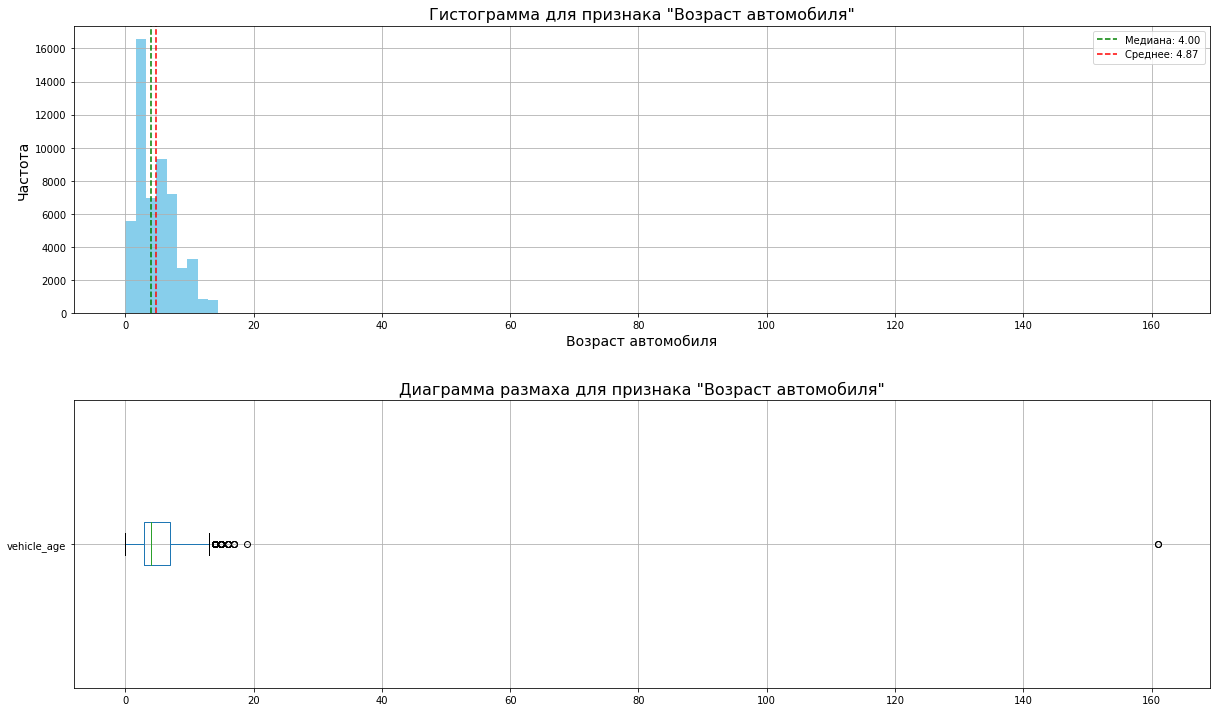

In [40]:
analyze_numerical_data(data, 'vehicle_age', 'Возраст автомобиля')

Возраст машин находится в диапазоне от 0 до 161 (явно аномалия в данных). Медианное значение - 4, среднее - 4.87. Межквартильный размах - от 3 до 7. Стандартное отклонение - 3,2.
В данных присутствует небольшое количество выбросов, размер датасета позволяет нам удалить их. Оставим данные только об автомобилях до 15 лет.

In [41]:
data = data[data['vehicle_age'] < 15]
data.shape[0] / temp.shape[0]

0.9487092874413312

Проблем в значениях категориальных признаков не обнаружено. Т.к. изменения не вносили, повторная проверка на дубликаты не требуется. Потеря данных на этапе предобработки составила 4,6%. 

Т.к. нами была создана специальная категория для учета возраста авто, этот признак мы можем не использовать.

### Корреляционный анализ

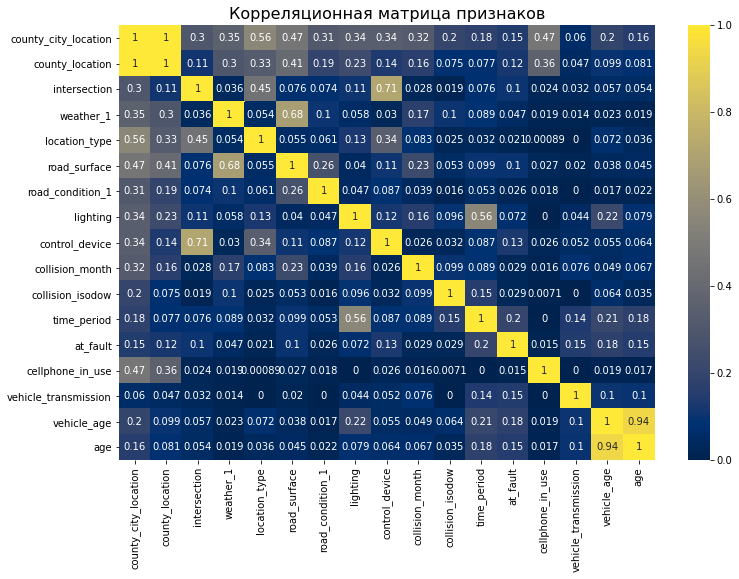

In [42]:
corr_matrix  = phik_matrix(data, interval_cols=['vehicle_age'])

plt.figure(figsize=(12, 8))
plt.title('Корреляционная матрица признаков', fontsize=TITLE_SIZE)
sns.heatmap(corr_matrix, annot=True, cmap='cividis');

Выявлена слабая взаимосвязь таргета с признаками county_city_location, county_location, intersection, road_surface, control_device, time_period, vehicle_transmission, vehicle_age, age.

Корреляционный анализ подтверждает наши решение: признаки `county_city_location` и `vehicle_age` использовать не будем. 

### Подготовка данных

In [43]:
data = data.drop(['county_city_location', 'vehicle_age'], axis=1)
data.columns

Index(['county_location', 'intersection', 'weather_1', 'location_type',
       'road_surface', 'road_condition_1', 'lighting', 'control_device',
       'collision_month', 'collision_isodow', 'time_period', 'at_fault',
       'cellphone_in_use', 'vehicle_transmission', 'age'],
      dtype='object')

In [44]:
data.duplicated().sum()

6658

In [45]:
data = data.drop_duplicates()
data.shape

(46705, 15)

Используя предоставленные данные, в качестве целевого признака используется виновность/невиновность участника ДТП. Данные о поездках, прошедших без аварий, отсутствуют. Т.е. наша модель будет показывать вероятность стать виновником ДТП.

Перед нами стоит задача бинарной классификации, обучение с учителем, дисбаланса классов в целевой переменной нет. Все входные признаки - категориальные. Заполним пропуски.

In [46]:
data.isna().sum()

county_location             0
intersection              165
weather_1                 163
location_type           25457
road_surface              322
road_condition_1          236
lighting                  152
control_device            206
collision_month             0
collision_isodow            0
time_period                 0
at_fault                    0
cellphone_in_use         4022
vehicle_transmission      569
age                         0
dtype: int64

In [47]:
data['intersection'] = data['intersection'].fillna(0)
data['cellphone_in_use'] = data['cellphone_in_use'].fillna(0)

for column in ['weather_1', 'location_type', 'road_surface', 
               'road_condition_1', 'lighting', 'control_device', 'vehicle_transmission']:
    data[column] = data[column].fillna('unknown')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46705 entries, 0 to 55086
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       46705 non-null  object 
 1   intersection          46705 non-null  float64
 2   weather_1             46705 non-null  object 
 3   location_type         46705 non-null  object 
 4   road_surface          46705 non-null  object 
 5   road_condition_1      46705 non-null  object 
 6   lighting              46705 non-null  object 
 7   control_device        46705 non-null  object 
 8   collision_month       46705 non-null  int64  
 9   collision_isodow      46705 non-null  int64  
 10  time_period           46705 non-null  object 
 11  at_fault              46705 non-null  int64  
 12  cellphone_in_use      46705 non-null  float64
 13  vehicle_transmission  46705 non-null  object 
 14  age                   46705 non-null  object 
dtypes: float64(2), int6

In [48]:
# Преобразуем типы некоторых столбцов
data['collision_month'] = data['collision_month'].astype(str)
data['collision_isodow'] = data['collision_isodow'].astype(str)
data['cellphone_in_use'] = data['cellphone_in_use'].astype(bool)
data['intersection'] = data['intersection'].astype(bool)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46705 entries, 0 to 55086
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   county_location       46705 non-null  object
 1   intersection          46705 non-null  bool  
 2   weather_1             46705 non-null  object
 3   location_type         46705 non-null  object
 4   road_surface          46705 non-null  object
 5   road_condition_1      46705 non-null  object
 6   lighting              46705 non-null  object
 7   control_device        46705 non-null  object
 8   collision_month       46705 non-null  object
 9   collision_isodow      46705 non-null  object
 10  time_period           46705 non-null  object
 11  at_fault              46705 non-null  int64 
 12  cellphone_in_use      46705 non-null  bool  
 13  vehicle_transmission  46705 non-null  object
 14  age                   46705 non-null  object
dtypes: bool(2), int64(1), object(12)
mem

Подготовим тренировочную и тестовые выборки для дальнейшего моделирования.

In [49]:
cat_cols = data.select_dtypes(exclude='number').columns.tolist()
target = 'at_fault'
# выделяем признаки и целевую переменную
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train.shape, X_test.shape

((35028, 14), (11677, 14))

__Промежуточный вывод__:
- подготовили набор данных в соответствии с требованиями заказчика;
- провели первичный набор факторов, необходимых для модели;
- предобработали данные, удалили дубликаты;
- провели исследовательский и корреляционный анализ данных;
- подготовили тренировочную и тестовые выборки.

## Подготовка моделей

Построим несколько моделей:
- CatBoostClassifier
- LightGBM
- RandomForestClassifier
- LogisticRegression
- DummyClassifier (для сравнения)

_Выбор метрики:_
Модель будет использоваться в работе рекомендательной системы. Для нас важно минимизировать ошибки, которые могут привести к опасным ситуациям (FN). Вместе в этим, большое количество FP предсказаний может привести к недовольству при использовании системы, в итоге "постоянные навязчивые рекомендации" будут игнорироваться. В качестве метрики будем использовать F1-score. Дополнительно учтем ROC-AUC для общей оценки качества модели.

Работать с каждой моделью будем отдельно, т.к. используется разный подход к работе с категориальными данными.

In [50]:
def search_best_estimator(model, param, X_train, y_train):
    """
    Функция ищет лучшую модель с помощью RandomizedSearchCV.
    Выводит на экран время поиска, лучшие параметры
    и F1-score на кросс-валидации.

    model - модель/пайплайн
    param - словарь с гиперпараметрами
    X_train - обучающая выборка
    y_train - целевая переменная

    Args:
        model (object): модель/пайплайн
        param (dict): словарь с гиперпараметрами
        X_train (pd.DataFrame): обучающая выборка
        y_train (pd.Series): целевая переменная

    Returns:
        object: rand_search - объект RandomizedSearchCV
    """

    start_time = time.time()

    rnd_search = RandomizedSearchCV(
        model,
        param,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        random_state=RANDOM_STATE,
        cv=5, #
        n_jobs=-1)

    rnd_search.fit(X_train, y_train)
    search_time = time.time() - start_time
    results = rnd_search.cv_results_
    # индекс лучшей модели по F1
    best_index = results['rank_test_f1'].argmin() 
    f1 = results["mean_test_f1"][best_index]
    roc_auc = results["mean_test_roc_auc"][best_index]
    print(f'Время поиска: {search_time} cекунд')
    print(f'Лучшие параметры: {rnd_search.best_params_}')
    print(f'F1-score на кросс-валидации: {f1}')
    print(f'ROC AUC на кросс-валидации: {roc_auc}')
    return rnd_search, f1, roc_auc 

### CatBoostClassifier

Предварительное кодирование категориальных данных не требуется, воспользуемся встроенными возможностями.

In [51]:
model_catboost = CatBoostClassifier(cat_features=cat_cols, random_seed=12345, verbose=0)

param_catboost = {
    'learning_rate': [0.03, 0.01, 0.1],
    'iterations': [200, 400, 600],  
    'depth': [4, 6, 8],
    'l2_leaf_reg': [0, 1, 3, 5]
}

catboost_model, f1_catboost, roc_auc_catboost = search_best_estimator(
    model_catboost, param_catboost, X_train, y_train)

Время поиска: 1307.7130391597748 cекунд
Лучшие параметры: {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 4}
F1-score на кросс-валидации: 0.6095297498321728
ROC AUC на кросс-валидации: 0.6174356283777632


### LGBMClassifier

In [52]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

for c in cat_cols:
    X_train_lgbm[c] = X_train_lgbm[c].astype('category')
    X_test_lgbm[c] = X_test_lgbm[c].astype('category')

In [53]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
param_lgbm = {
    'num_leaves': [16, 32, 64],
    'n_estimators': [200, 300, 500],
    'max_depth': [6, 8, 10],
    'min_child_samples': [5, 10, 20],
    'learning_rate': [0.01, 0.03, 0.1]
}

lgbm_model, f1_lgbm, roc_auc_lgbm = search_best_estimator(
    model_lgbm, param_lgbm, X_train_lgbm, y_train)

Время поиска: 383.07154178619385 cекунд
Лучшие параметры: {'num_leaves': 16, 'n_estimators': 200, 'min_child_samples': 10, 'max_depth': 6, 'learning_rate': 0.01}
F1-score на кросс-валидации: 0.6008897471601637
ROC AUC на кросс-валидации: 0.6174057395642808


### RandomForestClassifier

In [54]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),cat_cols)
    ],
    remainder = 'passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_tree = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', RandomForestClassifier(random_state=RANDOM_STATE))
    ]
)
param_rfc = {
    'models__min_samples_leaf': [4, 7, 9],
    'models__min_samples_split': [2, 3, 5],
    'models__n_estimators': [300, 500, 700],
    'models__max_depth': [5, 7, 10]}

tree_model, f1_tree, roc_auc_tree = search_best_estimator(pipe_tree, param_rfc, X_train, y_train)

Время поиска: 250.96917033195496 cекунд
Лучшие параметры: {'models__n_estimators': 300, 'models__min_samples_split': 2, 'models__min_samples_leaf': 4, 'models__max_depth': 5}
F1-score на кросс-валидации: 0.6177415595565031
ROC AUC на кросс-валидации: 0.6142736547160907


### LogisticRegression

In [55]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('cat', OneHotEncoder(drop='first', sparse=False,
                              handle_unknown='ignore'), cat_cols)
    ],
    remainder = 'passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

param_lr= {
        'models__C': [0.01, 0.1, 1, 10],
        'models__penalty': ['l2']
    }

rand_search_lr, f1_lr, roc_auc_lr = search_best_estimator(pipe_final, param_lr, X_train, y_train)

Время поиска: 107.92183494567871 cекунд
Лучшие параметры: {'models__penalty': 'l2', 'models__C': 0.01}
F1-score на кросс-валидации: 0.6111451355455754
ROC AUC на кросс-валидации: 0.6170797348000298


### DummyClassifier

In [56]:
model_dummy =  DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
dummy_model, f1_dummy, roc_auc_dummy = search_best_estimator(model_dummy, {}, X_train, y_train)

Время поиска: 0.2658078670501709 cекунд
Лучшие параметры: {}
F1-score на кросс-валидации: 0.5117428120033269
ROC AUC на кросс-валидации: 0.5


### Анализ моделей

In [57]:
data = {
    'Model': ['CatBoostClassifier', 'LightGBMClassifier',
               'RandomForestClassifier', 'LogisticRegression', 'DummyClassifier'],
    'F1': [f1_catboost, f1_lgbm, f1_tree, f1_lr, f1_dummy ],
    'ROC-AUC': [roc_auc_catboost, roc_auc_lgbm, roc_auc_tree, roc_auc_lr, roc_auc_dummy]
}
 
df = pd.DataFrame(data)
df.set_index('Model', inplace=True)
df

,F1,ROC-AUC
Model,,
CatBoostClassifier,0.609530,0.617436
LightGBMClassifier,0.600890,0.617406
RandomForestClassifier,0.617742,0.614274
LogisticRegression,0.611145,0.617080
DummyClassifier,0.511743,0.500000


__Промежуточный вывод__:

 Лучший результат показала модель RandomForestClassifier с параметрами 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5. F1-score на кросс-валидации: 0.618, ROC-AUC на кросс-валидации: 0.614.

## Проверка лучшей модели

### Анализ модели

In [58]:
def analyze_model(model, X_test, y_test):
    """
    Функция для анализа модели:
    - находит значение метрик ROC-AUC, F1-Score, Precision, Recall
    - выводит Confusion Matrix

    Args:
        model: модель
        X_test: признаки
        y_test: целевая переменная

    Returns:
        None
    """
    pred = model.predict(X_test)

    print('ROC AUC модели на тестовой выборке:', roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    print('F1 Score:', f1_score(y_test, pred))
    print('Precision:', precision_score(y_test, pred))
    print('Recall:', recall_score(y_test, pred))

    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.title('Матрица ошибок', fontsize=TITLE_SIZE)
    plt.ylabel('True label')
    plt.xlabel('Predicted')
    plt.show()

ROC AUC модели на тестовой выборке: 0.6223152649913894
F1 Score: 0.6282150007700601
Precision: 0.5914165579237349
Recall: 0.6698965347347676


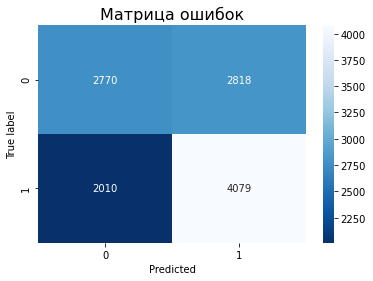

In [59]:
best_model = tree_model.best_estimator_
analyze_model(best_model, X_test, y_test)

<Figure size 576x432 with 0 Axes>

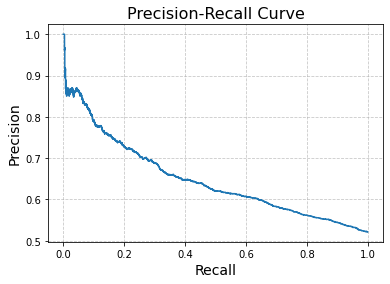

In [60]:
y_score = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.figure(figsize=(8, 6))
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title('Precision-Recall Curve', fontsize=TITLE_SIZE)
plt.xlabel('Recall', fontsize=LABEL_SIZE)
plt.ylabel('Precision', fontsize=LABEL_SIZE)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

График отображает зависимость точности (Precision) от полноты (Recall) для различных пороговых значений классификации. Чем ближе кривая к верхнему правому углу, тем лучше работа модели (и наоборот). Судя по графику, качество модели не очень хорошее - кривая ближе к нижнему левому углу. Матрица ошибок также говорит о том, что у модели имеются проблемы с разделением классов. Ошибок первого рода (FP) - 2818, ошибок второго рода (FN) - 2010. 

Метрики лучшей модели на тестовой выборке: F1 - 0.628, ROC-AUC - 0.622.

### Анализ важности признаков

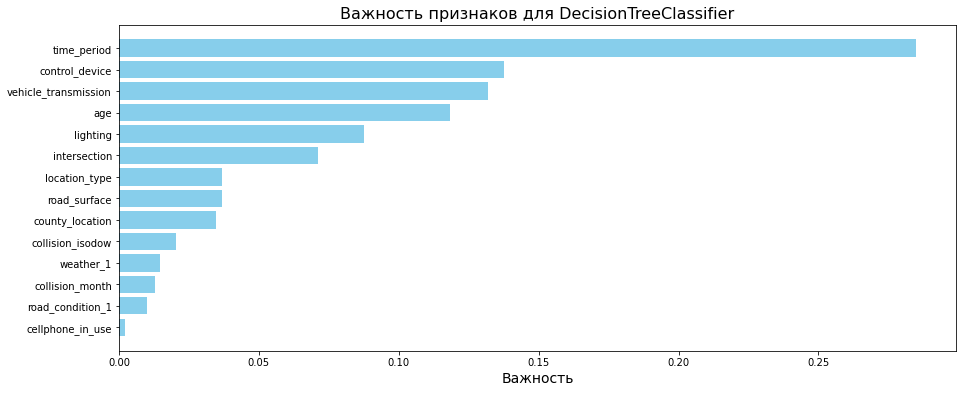

In [61]:
feature_importances = pd.DataFrame(
    {
        'feature': X_train.columns,
        'importance': tree_model.best_estimator_.named_steps['models'].feature_importances_
    }).sort_values(by='importance', ascending=True)

plt.figure(figsize=(15, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Важность', fontsize=LABEL_SIZE)
plt.title('Важность признаков для DecisionTreeClassifier', fontsize=TITLE_SIZE)
plt.show()


Топ-6 важных признаков в порядке убывания важности:
- time_period (06:00-11:59 - 'morning', 12:00-17:59 - 'afternoon', 18:00-23:59 - 'evening', 00:00-05:59 - night)
- control_device
- vehicle_transmission
- age ('age <= 3', '3 < age <= 5', '5 < age <= 10', 'age > 10')
- lightning
- intersection

Самым малозначимым признаком для модели является cellphone_in_use.

### Влияние фактора "time_period" на целевую переменную

Предполагаем, что в современных каршеринговых авто есть система синхронизации с сервером времени, которую можно использовать для получения точного времени и дальнейшего определения периода суток. 

In [62]:
predictions = best_model.predict(X_test)

data = pd.DataFrame({
    'at_fault': best_model.predict(X_test),
    'time_period': X_test['time_period']
}) 
grouped_data = (
    data
    .groupby('time_period')
    .agg(count=('at_fault', 'count'),
         share_of_fault=('at_fault', 'mean')         )
)
grouped_data['percentage_of_fault'] = round(grouped_data['share_of_fault'] * 100, 2)
grouped_data

,count,share_of_fault,percentage_of_fault
time_period,,,
afternoon,4728,0.515440,51.54
evening,2942,0.580218,58.02
morning,2787,0.558665,55.87
night,1220,0.980328,98.03


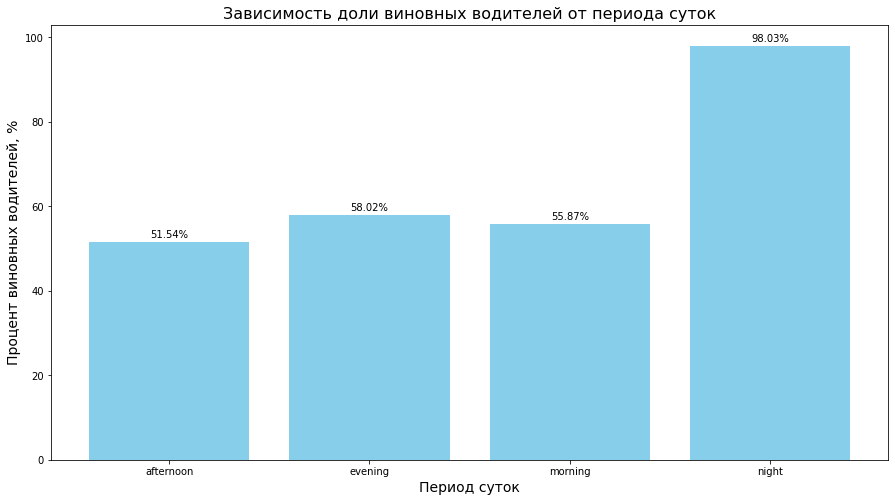

In [63]:
plt.figure(figsize=(15, 8))
plt.bar(grouped_data.index, grouped_data['percentage_of_fault'], color='skyblue')
plt.xlabel('Период суток', fontsize=LABEL_SIZE)
plt.ylabel('Процент виновных водителей, %', fontsize=LABEL_SIZE)
plt.title('Зависимость доли виновных водителей от периода суток', fontsize=TITLE_SIZE)
plt.xticks(rotation=0)
for i, percentage in enumerate(grouped_data['percentage_of_fault']):
    plt.text(i, percentage + 1, f'{percentage}%', ha='center')
plt.show()

В ночное время суток наибольший процент водителей - виновники ДТП. Самое "безопасное" время - утреннее и дневное, вечером доля водителей-виновников ДТП растет.

__Промежуточный вывод:__
- метрики лучшей модели на тестовой выборке: F1 - 0.628, ROC-AUC - 0.622. Модель требует улучшения, т.к. имеются проблемы с разделением классов. 
- самые важные признаки для модели: time_period, control_device, vehicle_transmission, age, самый малозначимый признак - cellphone_in_use.

## Общий вывод

В данном проекте мы изучили данные, предоставленные каршеринговой компанией: 
- общая информация о ДТП
- информация об участниках ДТП
- информация о пострадавших машинах

Мы разработали модель для предсказания того, окажется ли водитель виновным в ДТП: 
__RandomForestClassifier__ с параметрами __'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5__. Метрики лучшей модели на тестовой выборке: __F1 - 0.628, ROC-AUC - 0.622__. Модель требует доработки.

Самыми __важными факторами__ являются:
- период суток
- устройства управления
- тип КПП
- категория возраста авто
- освещенность
- является ли место перекрестком

Самым малозначимым признаком для модели является наличие cellphone_in_use.

Стоит __обратить внимание__ заказчика на следующие моменты:

- Заказчик планирует разработку системы, которая позволит оценить риск ДТП по выбранному маршруту движения. Однако предоставленные данные позволяют создать модель для предсказания того, станет ли водитель виновником аварии. Для проработки изначальной идеи заказчика нужны данные о поездках, во время которых ДТП не было. 
- Данные за 2012 год в базе представлены не в полном объеме, что может повлиять на результаты моделирования. Стоит проверить, даст ли использование данных с мая 2011 по апрель 2012 лучший результат.

__Идеи__ по работе над системой:
- добавить данные об успешных поездках, т.к. именно их не хватает для того, чтобы появился необходимый таргет - произошло или не произошло ДТП;
- добавить данные о профиле пользователей (например, остлеживание поведения пользователя (нарушение скоростного режима, игнорирование дорожной разметки, правил парковки и др.) позволит учесть склонность водителя к нарушению ПДД),
- рассмотреть возможность учета субъективной оценки пользователей после завершения маршрута, наколько безопасным он был,
- получить более свежие данные.

Адекватную системы оценки водительского риска при выдаче авто на основании имеющихся данных нельзя. Датасет нужно расширить данными о неаварийных поездках. В качестве дополнительных факторов рекомендуется учесть информацию о пользователях. Можно рассмотреть вопрос об использовании таких решений, как телематические системы и системы мониторинга водителя.